In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from tqdm.auto import tqdm

### Simple fully connected model for MNIST

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )
        self.start_layer = 0
        self.end_layer = len(self.model)

    def forward(self, x):
        x = torch.squeeze(x)
        if self.start_layer == 0:
            x = x.view(-1, 28*28)
        for i in range(self.start_layer, self.end_layer):
            x = self.model[i](x)
        if self.end_layer == len(self.model):
            x = F.log_softmax(x, dim=1)
        return x
    
    def set_start_layer(self, i):
        self.start_layer = i

    def set_end_layer(self, i):
        self.end_layer = i


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1600, 10)
        )
        self.start_layer = 0
        self.end_layer = len(self.model)

    def forward(self, x):
        for i in range(self.start_layer, self.end_layer):
            x = self.model[i](x)
        if self.end_layer == len(self.model):
            x = F.log_softmax(x, dim=1)
        return x
    
    def set_start_layer(self, i):
        self.start_layer = i

    def set_end_layer(self, i):
        self.end_layer = i


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)
torch.set_default_dtype(torch.float64)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor()
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [3]:
train_model = False
if train_model:
    model = ConvNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in tqdm(range(1, args.epochs + 1)):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

### Load the model for investigation

In [4]:
def load_model(filename: str, type: str='cnn', test: bool=False):
    """ 
    load the model from the .pt file and evaluate on the test set if requested
    :param filename: str of model save filename
    :param test: bool dictating if the model is tested
    :return: loaded model
    """
    modeldict = torch.load(filename)
    if type == 'cnn':
        model = ConvNet()
    else:
        model = Net()
    model.load_state_dict(modeldict)
    if test:
        test(model, device, test_loader)
    return model

In [5]:
input, clas = next(iter(test_loader))
model = load_model('mnist_cnn.pt')

Waarde van 'pixel' fluctueren van 0 naar 1 en kijken wat het effect is op de output van het model

Mogelijke richtingen: r as, r random, r gradient

Gradient: ipv loss.backward kan je y.backward of je hebt w.grad en x.grad (misschien met x.requiresGradient=True). \\

Torch sequential: hooks/forward hook. layer.addForwardHook(x,... lambda x: )\\

Ook backward hook voor de gradient. 

Importance estimation with imprinting:
https://openaccess.thecvf.com/content/CVPR2021W/MAI/papers/Liu_Layer_Importance_Estimation_With_Imprinting_for_Neural_Network_Quantization_CVPRW_2021_paper.pdf 

Importance estimation with pruning:
https://openaccess.thecvf.com/content_CVPR_2019/papers/Molchanov_Importance_Estimation_for_Neural_Network_Pruning_CVPR_2019_paper.pdf

### Run the modulated input through the model and save outputs

In [6]:
def direction(method: str, input: torch.Tensor, grad: torch.Tensor=None):
    """
    calculate the direction of a step given the requested direction type and the input
    :param method: string defining the method for calculating the direction ('axis', 'random' or 'gradient')
    :param input: input to the layer to be investigated
    :return: tensor array with the same shape as the input describing the direction
    """
    dir = torch.ones_like(input)
    match method:
        case 'axis':
            dir = torch.zeros_like(dir)
            dir = random_axis(dir)
        case 'random':
            dir = torch.rand_like(dir) #normal
        case 'gradient':
            dir = grad.T@torch.ones(grad.shape[0]) #normaliseren
        case _:
            warnings.warn('Unknown direction type, using all directions', RuntimeWarning)
            pass
    return dir

def random_axis(tensor: torch.Tensor): 
    """
    set a random value in an input-shaped tensor of zeros to 1, dictating a random direction along the axis to take the steps in
    :param tensor: input-shaped tensor of zeros
    :return: tensor of zeros and a 1
    """
    input_length = len(tensor.flatten())

    random_numbers = np.array(random.sample(range(0, input_length), input_length))
    random_numbers = random_numbers.reshape(np.array(tensor).shape)

    random_index = random.sample(range(0, input_length), 1)
    random_index = np.where(random_numbers == random_index)
    
    tensor[random_index] = 1
    return tensor

In [7]:
def multi_layer_gradient(layers, input, model):
    model.set_start_layer(layers[0])
    model.set_end_layer(layers[-1])
    grad = torch.autograd.functional.jacobian(model, input)
    return grad

In [8]:
def forward_runs(startinput: torch.Tensor, model, layergroups: list, dirtype: str=None):
    """
    run through the model while creating inputs at the different steps with the given direction. save the outputs for further inspection
    :param input: tensor input to the first layer
    :param model: neural network 
    :param dirtype: string describing the method used to find a direction
    :return: inputs into each layer with step adjustments, corresponding outputs, dirs, steps and grads
    """
    steps = np.logspace(-5,-1,5)
    startinput.requires_grad = True

    #for dicts:
    dictgroups = []
    dictsteps = []
    dictinputs = []
    dictoutputs = []
    dictdirs = []
    dictgrads = []

    for group in layergroups:
        input = startinput
        firstlayer = model.model[group[0]]

        firstlayer_idx = np.where(np.isin(model.model, firstlayer))[0][0]
        if firstlayer_idx > 0:
            model.set_start_layer(0)
            model.set_end_layer(firstlayer_idx)
            input = model(input)
        # print(firstlayer)
        # print(input.shape)
        grad = torch.autograd.functional.jacobian(firstlayer, input)
        # print(grad.shape)
        dir = direction(dirtype, input, grad)
        model.set_start_layer(group[0])
        model.set_end_layer(group[-1])

        dictgroups.append(str(group))
        dictsteps.append(0.)
        dictinputs.append(input.detach().clone())
        dictoutputs.append(model(input).detach().clone())
        dictdirs.append(dir)
        dictgrads.append(grad)

        for step in steps:
            newinput = input + step*dir
            newoutput = model(newinput)

            # layerinputs.append(newinput.detach().clone())
            # layeroutputs.append(newoutput.detach().clone())
            inp = newinput.detach().clone()
            outp = newoutput.detach().clone()

            dictgrad = torch.autograd.functional.jacobian(model, input)
            # print(dictgrad.shape)
            
            dictgroups.append(str(group))
            dictsteps.append(step)
            dictinputs.append(inp)
            dictoutputs.append(outp)
            dictdirs.append(dir)
            dictgrads.append(dictgrad)

    dic = {'group': dictgroups, 'step': dictsteps, 'input': dictinputs, 'output': dictoutputs, 'grad': dictgrads, 'dir': dictdirs}
    df = pd.DataFrame.from_dict(dic)
    model.set_start_layer(0)
    model.set_end_layer(len(model.model))
    return df

In [9]:
df = forward_runs(input[0], model, [[0,1]], 'grad')

/tmp/ipykernel_21078/2961953990.py:18: RuntimeWarning: Unknown direction type, using all directions
  warnings.warn('Unknown direction type, using all directions', RuntimeWarning)


f(x+ar) = f(x) + arf'(x)

En checken of dit binnen threshold blijft.

In [9]:
df

NameError: name 'df' is not defined

In [22]:
def calc_exp_act(df: pd.DataFrame):
    """ 
    calculate the expected outputs assuming linearity, and take the actual outputs from the model
    :param df: 
    :return: expected outputs assuming linearity and actual outputs
    """
    dictgroups = []
    dictsteps = []
    dictlins = []
    for group in np.unique(df['group']):
        # print(group)
        for step in np.unique(df['step']):
            dfoi = df[(df['group']==str(group)) & (df['step']==step)]

            step = list(dfoi['step'])[0]
            act = list(dfoi['output'])[0]
            grad = list(dfoi['grad'])[0]
            dir = list(dfoi['dir'])[0]

            nostep = list(df[(df['group'] == str(group)) & (df['step'] == 0.)]['output'])[0]
            # print(type(nostep), type(step), type(grad), type(dir))
            # print(act.shape)
            grad = torch.squeeze(grad)
            dir = torch.squeeze(dir)

            # print(grad.shape, dir.shape)
            print(grad.shape, dir.shape)
            print(nostep.shape)
            test = grad.flatten(start_dim=3)
            test2 = dir.flatten()
            print(np.matmul(test, test2).shape)
            print(test.shape)
            exp = nostep + step*np.matmul(grad, dir)

            diff = exp - act
            lin = np.linalg.norm(diff)

            dictgroups.append(group)
            dictsteps.append(step)
            dictlins.append(lin)

    dic = {'group': dictgroups, 'step': dictsteps, 'lin': lin}
    df = pd.DataFrame.from_dict(dic)
    return df
        
# exp, act = calc_exp_act(inputs, outputs, dirs, steps, model, grads)

In [23]:
lindf = calc_exp_act(df)
lindf

torch.Size([32, 26, 26, 28, 28]) torch.Size([28, 28])
torch.Size([32, 26, 26])
torch.Size([32, 26, 26])
torch.Size([32, 26, 26, 784])


RuntimeError: The size of tensor a (26) must match the size of tensor b (28) at non-singleton dimension 4

f(x+ar)=f(x) +arf'(x)

In [14]:
lindf['group']

0     [0, 1]
1     [0, 1]
2     [0, 1]
3     [0, 1]
4     [0, 1]
5     [0, 1]
6     [2, 3]
7     [2, 3]
8     [2, 3]
9     [2, 3]
10    [2, 3]
11    [2, 3]
Name: group, dtype: object

In [38]:
def plot(model, df: pd.DataFrame, dir: str):
    """ 
    plot the L2 norms per step size for each layer in the model
    :param model: model to be investigated
    :param lindf: 
    :param dir: str describing step direction
    """

    zero = np.zeros(6)

    fig, axs = plt.subplots(1, 1, layout='constrained', figsize=(7,4))
    groups = np.unique(df['group'])
    for i, group in enumerate(groups):
        dfoi = df[df['group'] == group]
        axs.plot(dfoi['step'], dfoi['lin'], label=f'{group}', alpha=0.7)
    # for ax in axs:
        
    axs.plot(dfoi['step'], zero, label='zero-line')
    
    axs.set_xscale('log')
    axs.legend()
    axs.set_ylabel('$L_{2,2}$ norm')
    axs.set_xlabel('Step size')
    fig.suptitle(f"Linearity per step size in direction '{dir}'")

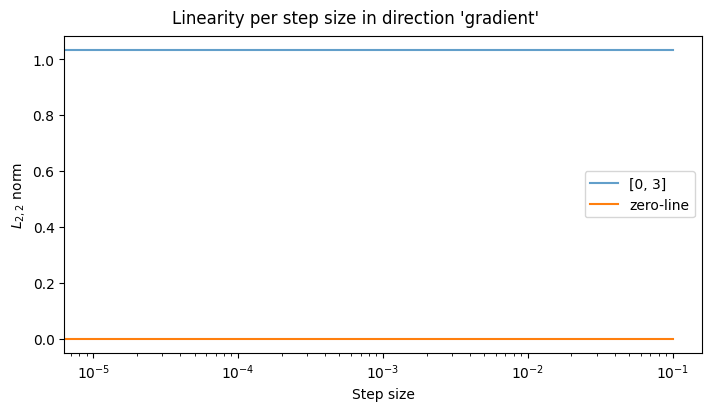

In [39]:
plot(model, lindf, 'gradient')

In [31]:
model.model[4]

Linear(in_features=512, out_features=10, bias=True)

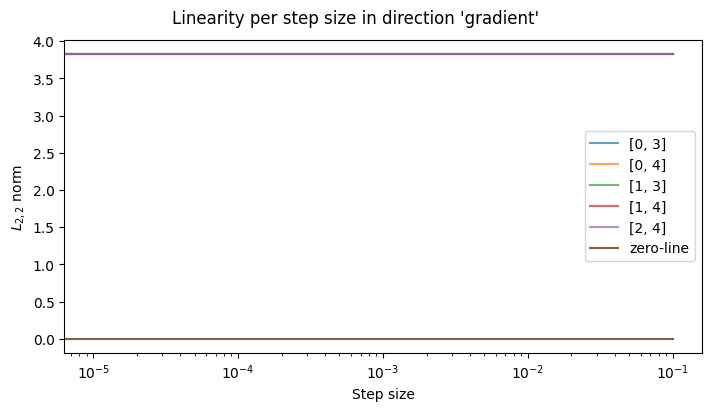

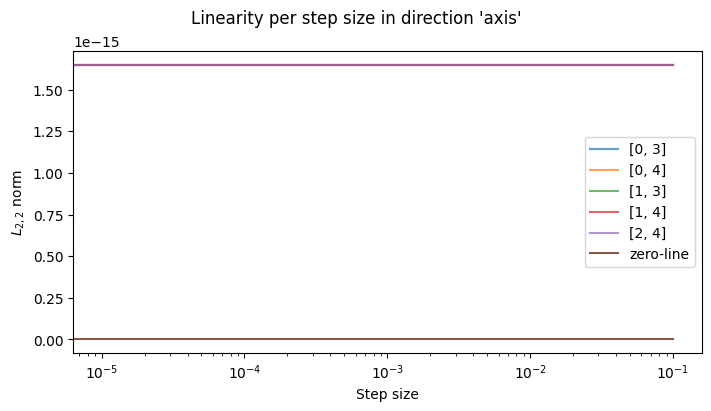

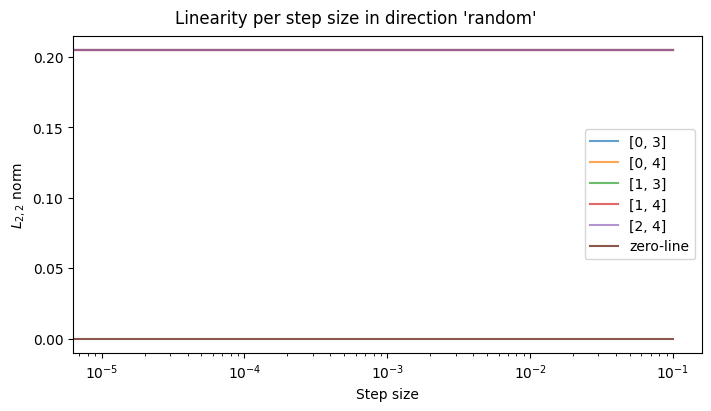

In [40]:
def pipeline(model_name: str, dir: str, test_loader=test_loader):
    """
    calculate linearity per layer given a model and test loader, and plot the results
    :param model_name: string of model save filename
    :param test_loader: test data loader
    """
    model = load_model(model_name)
    input = next(iter(test_loader))[0]
    df = forward_runs(input[0], model, [[0,3],[0,4],[1,3],[1,4],[2,4]], dir)
    lindf = calc_exp_act(df)
    plot(model, lindf, dir)


pipeline('mnist_cnn.pt', 'gradient')
pipeline('mnist_cnn.pt', 'axis')
pipeline('mnist_cnn.pt', 'random')

checken of we andere resultaten hebben met doubles.\
waarom geen 0 bij kleine stappen? \
checken wat gradient van ReLU is bij x=0
bij linear layers verwachten we lineariteit

wat als we een groep lagen lineair benadert?\
kan je een groep lagen vervangen door een lineaire laag met gewichten berekend adhv de gradient van de lagen?

### Using hooks

In [ ]:
def input_output_hook(self, module, input, output):
    self.input = input
    self.output = output

def gradient_hook(self, module, input: torch.tensor, output: torch.tensor):
    output.backward()